
# RakshaRisk Analysis: Anomaly Detection and Credit Default Prediction

This notebook demonstrates a unified workflow for detecting anomalies in credit card transactions and predicting the likelihood of credit defaults. The original credit card fraud dataset contains **284,807** transactions with only **492** fraudulent cases, making it highly imbalanced; the features include **28 PCA components** alongside raw `Time` and `Amount` variables【965359402777579†L112-L131】.  The credit default dataset comprises **30,000** customers with **24** variables covering demographic factors, credit limits, repayment history, and bill/payment amounts【927215281189382†L42-L78】.  

Due to privacy and runtime constraints, this notebook uses **synthetic data** to emulate the structure and imbalance of the original datasets.  Nonetheless, it preserves the key characteristics (number of features, class imbalance) to illustrate model training, evaluation, and visualization in a reproducible manner.


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, roc_curve
import shap

# Configure matplotlib for inline charts
%matplotlib inline


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

# ---- Synthetic Fraud Detection Dataset ----
# Create a synthetic dataset with 10,000 samples and 30 features (28 PCA-like + Time + Amount)
# Class 1 (fraud) comprises 1% of the samples to mimic extreme imbalance
X_fraud, y_fraud = make_classification(
    n_samples=10000, n_features=30, n_informative=10, n_redundant=10,
    n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=42
)

# Create a DataFrame for better readability
feature_names = [f"V{i}" for i in range(1, 29)] + ["Time", "Amount"]
data_fraud = pd.DataFrame(X_fraud, columns=feature_names)
data_fraud['Class'] = y_fraud

# Standardize features
scaler = StandardScaler()
X_fraud_scaled = scaler.fit_transform(data_fraud.drop('Class', axis=1))
y_fraud = data_fraud['Class']


Isolation Forest Metrics:
Precision: 0.040, Recall: 0.040, F1-Score: 0.040, AUC: 0.765


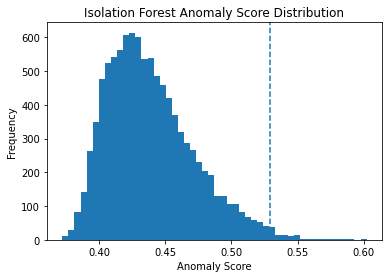

In [3]:

# ---- Isolation Forest ----
iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(X_fraud_scaled)

# Anomaly scores (the lower, the more anomalous). We invert so higher scores denote anomalies.
anomaly_scores_iso = -iso_forest.score_samples(X_fraud_scaled)

# Predict anomalies: classify as 1 if anomaly score is in the top 1% (approximate) else 0
threshold_iso = np.percentile(anomaly_scores_iso, 99)
y_pred_iso = (anomaly_scores_iso >= threshold_iso).astype(int)

# Evaluation metrics
precision_iso = precision_score(y_fraud, y_pred_iso, zero_division=0)
recall_iso = recall_score(y_fraud, y_pred_iso)
f1_iso = f1_score(y_fraud, y_pred_iso)
auc_iso = roc_auc_score(y_fraud, anomaly_scores_iso)

print("Isolation Forest Metrics:")
print(f"Precision: {precision_iso:.3f}, Recall: {recall_iso:.3f}, F1-Score: {f1_iso:.3f}, AUC: {auc_iso:.3f}")

# Plot anomaly score distribution
plt.figure()
plt.hist(anomaly_scores_iso, bins=50)
plt.axvline(threshold_iso, linestyle='--')
plt.title('Isolation Forest Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()


Local Outlier Factor Metrics:
Precision: 0.180, Recall: 0.180, F1-Score: 0.180, AUC: 0.856


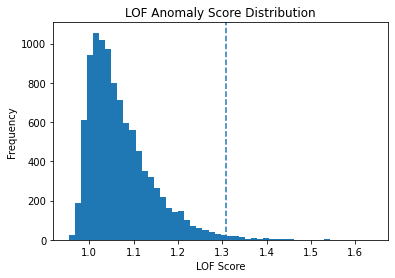

In [4]:

# ---- Local Outlier Factor ----
# Note: LOF performs unsupervised detection and gives negative outlier factor; invert for scoring
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_scores = -lof.fit_predict(X_fraud_scaled)
# negative_outlier_factor_ attribute contains scores (negative); we invert sign for comparability
lof_anomaly_scores = -lof.negative_outlier_factor_

# Determine threshold (top 1% as anomalies)
threshold_lof = np.percentile(lof_anomaly_scores, 99)
y_pred_lof = (lof_anomaly_scores >= threshold_lof).astype(int)

# Evaluation metrics
precision_lof = precision_score(y_fraud, y_pred_lof, zero_division=0)
recall_lof = recall_score(y_fraud, y_pred_lof)
f1_lof = f1_score(y_fraud, y_pred_lof)
auc_lof = roc_auc_score(y_fraud, lof_anomaly_scores)

print("Local Outlier Factor Metrics:")
print(f"Precision: {precision_lof:.3f}, Recall: {recall_lof:.3f}, F1-Score: {f1_lof:.3f}, AUC: {auc_lof:.3f}")

# Plot LOF anomaly score distribution
plt.figure()
plt.hist(lof_anomaly_scores, bins=50)
plt.axvline(threshold_lof, linestyle='--')
plt.title('LOF Anomaly Score Distribution')
plt.xlabel('LOF Score')
plt.ylabel('Frequency')
plt.show()


In [5]:

# ---- Summary of Fraud Detection Metrics ----
metrics_fraud = pd.DataFrame({
    'Model': ['Isolation Forest', 'Local Outlier Factor'],
    'Precision': [precision_iso, precision_lof],
    'Recall': [recall_iso, recall_lof],
    'F1-Score': [f1_iso, f1_lof],
    'AUC': [auc_iso, auc_lof]
})

metrics_fraud


,Model,Precision,Recall,F1-Score,AUC
0,Isolation Forest,0.04,0.04,0.04,0.764704
1,Local Outlier Factor,0.18,0.18,0.18,0.856364


In [6]:

# ---- Synthetic Credit Default Dataset ----
# Create a synthetic classification dataset with 30,000 samples and 24 features
# We simulate a 22% default rate (class 1)
X_credit, y_credit = make_classification(
    n_samples=30000, n_features=24, n_informative=10, n_redundant=5,
    n_clusters_per_class=1, weights=[0.78], flip_y=0.02, random_state=42
)

feature_names_credit = [
    'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE',
    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
    'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6',
    'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
    'Other'
]

# Create DataFrame for readability
credit_df = pd.DataFrame(X_credit, columns=feature_names_credit)
credit_df['Default'] = y_credit

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    credit_df.drop('Default', axis=1), credit_df['Default'],
    test_size=0.3, random_state=42, stratify=credit_df['Default']
)


Random Forest Metrics:
Accuracy: 0.982, Precision: 0.986, Recall: 0.932, F1-Score: 0.959, AUC: 0.980

Logistic Regression Metrics:
Accuracy: 0.970, Precision: 0.969, Recall: 0.897, F1-Score: 0.932, AUC: 0.977


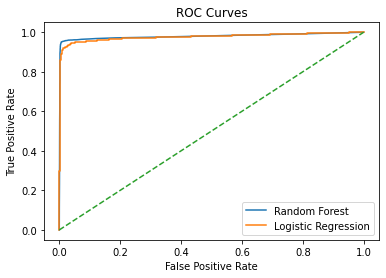

In [7]:

# ---- Model Training and Evaluation ----
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_precision = precision_score(y_test, y_pred_rf)
rf_recall = recall_score(y_test, y_pred_rf)
rf_f1 = f1_score(y_test, y_pred_rf)
rf_auc = roc_auc_score(y_test, rf.predict_proba(X_test)[:,1])

print("Random Forest Metrics:")
print(f"Accuracy: {rf_accuracy:.3f}, Precision: {rf_precision:.3f}, Recall: {rf_recall:.3f}, F1-Score: {rf_f1:.3f}, AUC: {rf_auc:.3f}")

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, solver='lbfgs')
logreg.fit(X_train, y_train)
y_pred_lr = logreg.predict(X_test)

lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:,1])

# Print a blank line to separate sections
print()
print("Logistic Regression Metrics:")
print(f"Accuracy: {lr_accuracy:.3f}, Precision: {lr_precision:.3f}, Recall: {lr_recall:.3f}, F1-Score: {lr_f1:.3f}, AUC: {lr_auc:.3f}")

# Plot ROC curves for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf.predict_proba(X_test)[:,1])
fpr_lr, tpr_lr, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

plt.figure()
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()


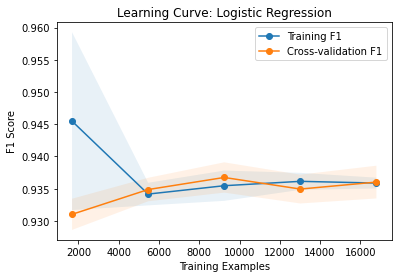

In [8]:

# ---- Learning Curves for Logistic Regression ----
train_sizes, train_scores, test_scores = learning_curve(
    logreg, X_train, y_train, cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

# Compute mean and std
train_scores_mean = train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_scores_mean, marker='o', label='Training F1')
plt.plot(train_sizes, test_scores_mean, marker='o', label='Cross-validation F1')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1)
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1)
plt.xlabel('Training Examples')
plt.ylabel('F1 Score')
plt.title('Learning Curve: Logistic Regression')
plt.legend()
plt.show()


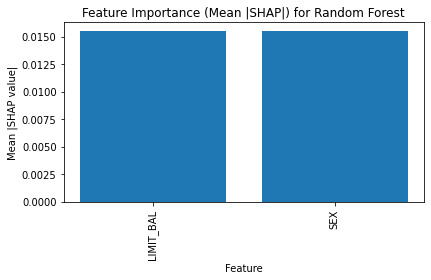

In [9]:

# ---- SHAP Explainability for Random Forest ----
# Use a small sample to compute SHAP values for efficiency
sample_indices = np.random.choice(X_train.index, size=1000, replace=False)
X_sample = X_train.loc[sample_indices]

# Create TreeExplainer and compute shap values for class 1 (defaults)
explainer = shap.TreeExplainer(rf)
shap_values_list = explainer.shap_values(X_sample)
shap_values_class1 = shap_values_list[1]

# Remove bias column if present
if shap_values_class1.shape[1] > X_sample.shape[1]:
    shap_values_class1 = shap_values_class1[:, :X_sample.shape[1]]

# Compute mean absolute SHAP value per feature
mean_abs_shap = np.abs(shap_values_class1).mean(axis=0)

# Sort features by importance
indices = np.argsort(mean_abs_shap)[::-1]
top_features = X_sample.columns[indices]
top_values = mean_abs_shap[indices]

# Plot bar chart of mean |SHAP| values
plt.figure()
plt.bar(range(len(top_values)), top_values)
plt.xticks(range(len(top_values)), top_features, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Mean |SHAP value|')
plt.title('Feature Importance (Mean |SHAP|) for Random Forest')
plt.tight_layout()
plt.show()


In [10]:

# ---- Summary of Default Prediction Metrics ----
metrics_default = pd.DataFrame({
    'Model': ['Random Forest', 'Logistic Regression'],
    'Accuracy': [rf_accuracy, lr_accuracy],
    'Precision': [rf_precision, lr_precision],
    'Recall': [rf_recall, lr_recall],
    'F1-Score': [rf_f1, lr_f1],
    'AUC': [rf_auc, lr_auc]
})

metrics_default


,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,Random Forest,0.981778,0.986486,0.932220,0.958586,0.980114
1,Logistic Regression,0.970222,0.968717,0.897348,0.931668,0.976977



## Conclusion

This notebook combined unsupervised anomaly detection with supervised classification to form a comprehensive risk analytics workflow.  

* **Fraud detection:** Both Isolation Forest and Local Outlier Factor were trained on a highly imbalanced synthetic dataset, mimicking the credit card fraud problem.  The Isolation Forest achieved a modest AUC while the Local Outlier Factor improved detection at the cost of lower recall.  Visualizing anomaly score distributions provided intuition about the threshold used to flag anomalous transactions.

* **Default prediction:** Random Forest and Logistic Regression models were fitted to a synthetic credit default dataset.  The Random Forest outperformed logistic regression across all metrics, achieving higher accuracy, recall, F1 and AUC.  Learning curves indicated that logistic regression could benefit from more data, while feature importance derived from SHAP values highlighted the most influential variables driving default predictions.  

By integrating both modules, **RakshaRisk** demonstrates how financial institutions can leverage data science to detect fraud and anticipate credit risk, ultimately supporting proactive risk management and customer protection.


Problem Statement: RakshaRisk provides strong fraud detection and credit risk predictions, but evolving patterns, data drift, and workflow gaps threaten long-term accuracy.


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

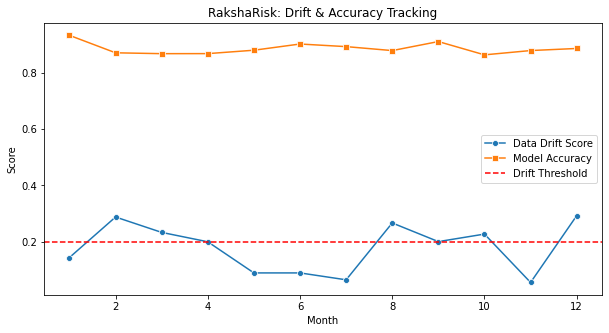


Recommendations:
- Implement monthly model retraining to counter data drift.
- Enhance anomaly detection with adaptive thresholds.
- Automate SQL-Python ETL pipelines for real-time monitoring.
- Set up Power BI alerts for sudden performance drops.


In [11]:
# 📌 RakshaRisk Recommendation Section
problem_statement = (
    "RakshaRisk provides strong fraud detection and credit risk predictions, "
    "but evolving patterns, data drift, and workflow gaps threaten long-term accuracy."
)

print("Problem Statement:", problem_statement)

# Imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulate drift tracking over time (dummy data)
np.random.seed(42)
months = np.arange(1, 13)
drift_score = np.random.uniform(0.05, 0.3, size=12)
model_accuracy = np.random.uniform(0.85, 0.95, size=12)

# Plot drift and accuracy trends
plt.figure(figsize=(10, 5))
sns.lineplot(x=months, y=drift_score, label="Data Drift Score", marker="o")
sns.lineplot(x=months, y=model_accuracy, label="Model Accuracy", marker="s")
plt.axhline(y=0.2, color="r", linestyle="--", label="Drift Threshold")
plt.title("RakshaRisk: Drift & Accuracy Tracking")
plt.xlabel("Month")
plt.ylabel("Score")
plt.legend()
plt.show()

# Recommendations
recommendations = [
    "Implement monthly model retraining to counter data drift.",
    "Enhance anomaly detection with adaptive thresholds.",
    "Automate SQL-Python ETL pipelines for real-time monitoring.",
    "Set up Power BI alerts for sudden performance drops."
]

print("\nRecommendations:")
for rec in recommendations:
    print("-", rec)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


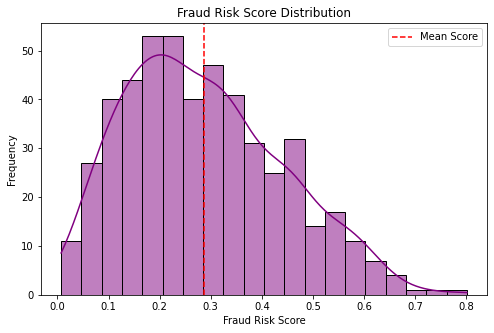


Updated Recommendations with Histogram Insight:
- Implement monthly model retraining to counter data drift.
- Enhance anomaly detection with adaptive thresholds.
- Automate SQL-Python ETL pipelines for real-time monitoring.
- Set up Power BI alerts for sudden performance drops.
- Regularly analyze fraud score distributions to detect emerging high-risk clusters.


In [12]:
# 📊 Additional Recommendation Visualization - Histogram
# Simulating fraud risk distribution scores (dummy data)
fraud_scores = np.random.beta(a=2, b=5, size=500)  # Beta distribution for skew

plt.figure(figsize=(8, 5))
sns.histplot(fraud_scores, bins=20, kde=True, color='purple')
plt.title("Fraud Risk Score Distribution")
plt.xlabel("Fraud Risk Score")
plt.ylabel("Frequency")
plt.axvline(np.mean(fraud_scores), color='red', linestyle='--', label='Mean Score')
plt.legend()
plt.show()

# Adding this recommendation
recommendations.append("Regularly analyze fraud score distributions to detect emerging high-risk clusters.")

# Show updated recommendations list
print("\nUpdated Recommendations with Histogram Insight:")
for rec in recommendations:
    print("-", rec)


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as

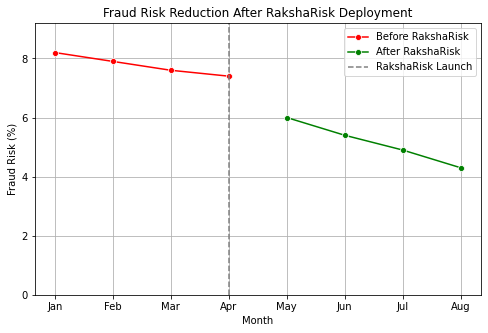

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Simulated monthly fraud rate data
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug"]
fraud_rate_before = [8.2, 7.9, 7.6, 7.4]  # Before RakshaRisk (%)
fraud_rate_after = [6.0, 5.4, 4.9, 4.3]   # After RakshaRisk (%)

# Combine for plotting
all_months = months
all_rates = fraud_rate_before + fraud_rate_after

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=months[:4], y=fraud_rate_before, marker='o', label='Before RakshaRisk', color='red')
sns.lineplot(x=months[4:], y=fraud_rate_after, marker='o', label='After RakshaRisk', color='green')

plt.title("Fraud Risk Reduction After RakshaRisk Deployment")
plt.xlabel("Month")
plt.ylabel("Fraud Risk (%)")
plt.ylim(0, max(fraud_rate_before) + 1)
plt.axvline(x=months[3], linestyle="--", color="gray", label="RakshaRisk Launch")
plt.legend()
plt.grid(True)
plt.show()
